# Explore Weather Data from BSEC Weather Stations

Welcome! This notebook will demonstrate how to use the MSD-LIVE data exploration service to visualize, transform, and download a subset of data collected from weather stations around the Baltimore area.

You can find the original dataset record at [https://doi.org/10.57931/2476281](https://doi.org/10.57931/2476281).


### Install Dependencies

First, we need to install a few libraries that we will use to read and transform the data.

To do so, we'll use the `!` directive to access the shell and then use `pip` to install our dependencies as specified in the accompanying [`requirements.txt`](requirements.txt).

To prevent the log messages from overflowing this notebook, we'll silence the output by directing informational messages into oblivion.


In [1]:

!pip install -r requirements.txt > /dev/null



If you find a need for other libraries, you can use a similar technique to install them directly, for instance by running `!pip install matplotlib`


### Import Dependencies

Now we can import the libraries we want to use explore the dataset.


In [2]:
import geopandas as gpd
import pandas as pd
import contextily as cx

from glob import glob
import os


### Find the Data

In this MSD-LIVE Jupyter environment, the dataset location is stored in the `DATA_DIR` environment variable.

We can again use the `!` directive to list the contents of this directory using shell commands, and we can use Python's `os.getenv()` method to get the path in code.

The data is also mounted to the `/data` directory in this Jupyter environment, so you can use the File Browser to see the available files and directory structure.


In [3]:

!ls $DATA_DIR


daily  Stations_Locations.csv


### Explore the Data

Now let's use `pandas` and `geopandas` to read the CSV file of weather station locations.


In [4]:

# Read the CSV using the DATA_DIR environment variable as the path
stations = pd.read_csv(f'{os.getenv("DATA_DIR")}/Stations_Locations.csv')[[
    # Select a few interesting columns
    'Station ID', 'Site Name', 'Longitude', 'Latitude'
]]

# Convert the coordinates to a geometry column using geopandas
stations = gpd.GeoDataFrame(
    stations, geometry=gpd.points_from_xy(stations.Longitude, stations.Latitude)
).set_crs('epsg:4326')

# View the first few records
stations.head()


,Station ID,Site Name,Longitude,Latitude,geometry
0,AAC,Allen AME Church,-76.636494,39.291360,POINT (-76.63649 39.29136)
1,ABL,Abell,-76.611476,39.327251,POINT (-76.61148 39.32725)
2,AES,Arlington Elementary School,-76.684446,39.350266,POINT (-76.68445 39.35027)
3,AGC,Amazing Grace Church,-76.582858,39.298248,POINT (-76.58286 39.29825)
4,ARK,Ark Church,-76.600797,39.311425,POINT (-76.6008 39.31143)



We can plot the stations locations on top of a basemap using `contextily` to get a sense for their spatial locations.


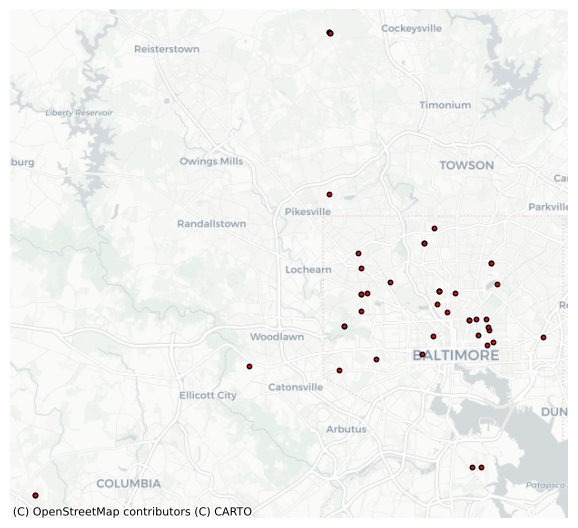

In [5]:

# Reproject the geometries to Web Mercator, then plot on top of a muted basemap
ax = stations.to_crs('epsg:3857').plot(
    figsize=(7.2, 7.2), marker='o', markersize=10,
    color='red', edgecolor='black', linewidth=1,
)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_axis_off()



### Subset the Data

Let's figure out the mean daily temperature at each station on your birthday!

Update your birthday below, then we'll read in all the CSV files for 2024 and select the observations on the chosen date.


In [6]:

# NOTE that the dataset currently only goes through October, so you may need to fudge your birthday a little to see data...
birthday_month = 10
birthday_day   = 31


In [7]:

# Read in each daily file, select the date, and add the observations to a new dataframe

daily_files = sorted(glob(f'{os.getenv("DATA_DIR")}/daily/2024/*.csv'))

birthday_data = []

for file in daily_files:
    
    df = pd.read_csv(file)
    
    # ensure the dates are datetime objects
    df['obsTimeUtc'] = pd.to_datetime(df.obsTimeUtc)
    
    # add observations on the chosen date to a list
    birthday_data.append(
        df[
            (df.obsTimeUtc.dt.month == birthday_month) &
            (df.obsTimeUtc.dt.day   == birthday_day)
        ]
    )

# combine all observations from all weather stations on the chosen date into a new dataframe
birthday_data = pd.concat(birthday_data, ignore_index=True)

# View the first few records
birthday_data.head()


,stationID,tz,obsTimeUtc,obsTimeLocal,epoch,lat,lon,solarRadiationHigh,uvHigh,winddirAvg,...,windchillLow,windchillAvg,heatindexHigh,heatindexLow,heatindexAvg,pressureMax,pressureMin,pressureTrend,precipRate,precipTotal
0,BSEC-AAC,America/New_York,2024-10-31 00:00:00,10/30/2024,1.730347e+09,39.291284,-76.636279,276.8,2.0,260.000000,...,8.9,15.700000,25.900000,8.900000,15.700000,1027.70,1021.61,-0.200000,0.0,0.0
1,BSEC-AES,America/New_York,2024-10-31 00:00:00,10/30/2024,1.730347e+09,39.350000,-76.684000,391.7,3.0,108.000000,...,9.3,17.000000,25.100000,9.300000,16.900000,1023.40,1017.51,-0.190000,0.0,0.0
2,BSEC-AGC,America/New_York,2024-10-31 00:00:00,10/30/2024,1.730347e+09,39.298257,-76.582909,453.0,4.0,249.000000,...,9.8,16.700000,26.100000,9.800000,16.700000,1018.39,1012.39,-0.210000,0.0,0.0
3,BSEC-ARK2,America/New_York,2024-10-31 04:00:00,10/31/2024,NaN,39.311182,-76.602894,519.0,NaN,70.222222,...,13.1,20.618403,27.599872,12.867778,20.583471,1018.70,1011.70,1015.775556,0.0,0.0
4,BSEC-ARK,America/New_York,2024-10-31 00:00:00,10/30/2024,1.730347e+09,39.311493,-76.600772,421.7,4.0,133.000000,...,10.5,17.600000,25.900000,10.500000,17.600000,1022.38,1016.49,-0.210000,0.0,0.0


<br/>


Let's create a histogram of all the temperatures to see the distribution of observations across weather stations:


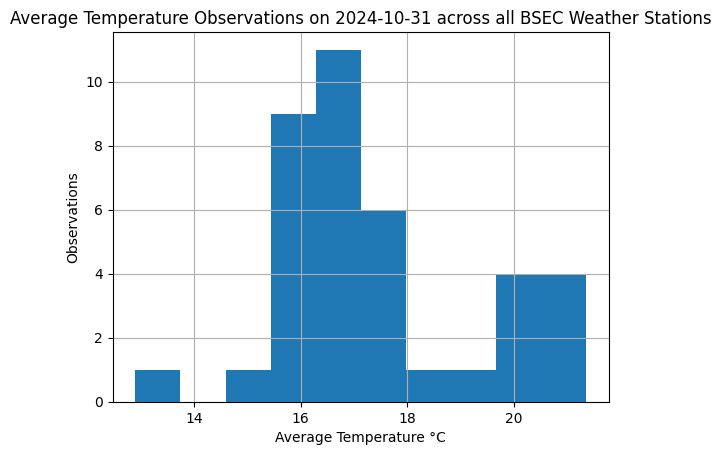

In [8]:

ax = birthday_data.tempAvg.hist();
ax.set_xlabel('Average Temperature °C');
ax.set_ylabel('Observations');
ax.set_title(f'Average Temperature Observations on 2024-{str(birthday_month).zfill(2)}-{str(birthday_day).zfill(2)} across all BSEC Weather Stations');


<br/>


### Saving the Data Subset

We can also save this new dataframe and download it to a local device for later use.

There are two ways to do this in the MSD-LIVE Jupyter environment.

* The easy way: for small files like this one, we can just write the file into the working directory and download it using the File Browser within Jupyter.
* For larger files (>100MB), we need to copy the file into our `scratch` directory and then use the MSD-LIVE CLI from our local device to download it.

We'll demonstrate the first option here and then show you how to copy the file to your `scratch`. For more information on downloading from the `scratch` folder, check out [How to download files from your scratch directory using our CLI](https://dev.msdlive.org/sb-minimal/help/resources/quick-guides/jupyter-notebooks#scratch-download).




<br/>

In [9]:

# Save the birthday subset dataframe to the current directory
birthday_data.to_csv('birthday_weather_station_data.csv', index=False)



You should now be able to see the data in the file explorer at [/notebooks/birthday_weather_station_data.csv](birthday_weather_station_data.csv). Right click this file in the File Browser and select "Download" to copy the file locally.

If the file was too big to download directly, you could first right click it and select "Copy to Scratch", and then follow the directions linked above to use the MSD-LIVE CLI to download from your `scratch` directory.


<br/>

Thanks for following along; you should now be empowered to explore the data for your own purposes!